In [18]:
from typing import Callable
from functools import partial

import matplotlib.pyplot as plt

import torch
from torch.optim import LBFGS

In [19]:
def get_curve(
    weights: torch.Tensor,
    point_0: torch.Tensor,
    point_1: torch.Tensor,
    n: int = 10,
    *,
    decoder: Callable[[torch.Tensor], torch.Tensor] = lambda x: x
) -> torch.Tensor:
    """
    Get the energy of a curve defined by a set of weights and two points

    :param weights: the weights of the curve outside of the endpoints
        shape (embedding_dim, curve_degree - 2)
    :param point_0: the starting point of the curve
        shape (embedding_dim)x
    :param point_1: the ending point of the curve
        shape (embedding_dim)
    :param n: the number of intermidaite points to use for the approximation (including endpoints)
    :param decoder: a function that maps the curve to the data manifold
        input shape (n, embedding_dim)
        output shape (n, decoder_dim)
    """
    emb_dim = point_0.shape[0]
    curve_degree = weights.shape[1] + 2

    w_i0 = torch.zeros((emb_dim, 1))
    w_iK = - weights.sum(dim=1, keepdim=True)
    _weights = torch.cat([w_i0, weights, w_iK], dim=1)

    t = torch.linspace(0, 1, n)[:,None] # shape (n, 1)
    exponents = torch.arange(0, curve_degree)[None, :] # shape (1, curve_degree)
    t_polynoal = t ** exponents # shape (n, curve_degree)

    polynomial_interpolation_displacement = t_polynoal @ _weights.T # shape (n, emb_dim)
    point_interpolation = (1 - t) * point_0[None, :] + t * point_1[None, :] # shape (n, emb_dim)
    points = point_interpolation + polynomial_interpolation_displacement

    return decoder(points) # shape (n, decoder_dim)


def get_curve_energy(
    weights: torch.Tensor,
    point_0: torch.Tensor,
    point_1: torch.Tensor,
    n: int = 10,
    *,
    decoder: Callable[[torch.Tensor], torch.Tensor] = lambda x: x,
    metric: Callable[[torch.Tensor], torch.Tensor] = lambda x: torch.ones_like(x),
    return_length: bool = False
) -> torch.Tensor:
    """
    Get the energy of a curve defined by a set of weights and two points

    :param weights: the weights of the curve outside of the endpoints
        shape (embedding_dim, curve_degree - 2)
    :param point_0: the starting point of the curve
        shape (embedding_dim)x
    :param point_1: the ending point of the curve
        shape (embedding_dim)
    :param n: the number of intermidaite points to use for the approximation (including endpoints)
    :param decoder: a function that maps the curve to the data manifold
        input shape (n, embedding_dim)
        output shape (n, decoder_dim)
    :param metric: a function that returns the local norm of the data manifold in each dimension
        input shape (n-1, embedding_dim/decoder_dim)
        output shape (n-1, embedding_dim/decoder_dim)
    """
    decoded_points = get_curve(weights, point_0, point_1, n, decoder=decoder)

    secant = torch.diff(decoded_points, dim=0)
    secant_mid_point = decoded_points[:-1] + secant / 2
    lengths = torch.norm(secant * metric(secant_mid_point), dim=1)
    energies = torch.square(lengths)
    return (energies, lengths)[return_length].sum()


def closure(optimizer: LBFGS, loss_fn: Callable[[], torch.Tensor]) -> torch.Tensor:
    """
    The closure function for the LBFGS optimizer
    """
    optimizer.zero_grad()
    loss = loss_fn()
    loss.backward()
    return loss


In [20]:
n = 10
emb_dim = 2
curve_degree = 5

weights = torch.randn(emb_dim, curve_degree - 2, requires_grad=True)
point_0 = torch.randn(emb_dim, requires_grad=False)
point_1 = torch.randn(emb_dim, requires_grad=False)

metric = lambda x: (1 + torch.norm(x, dim=1) ** 2)[:, None] * torch.ones((1, x.shape[1]))

eps = 1e-3
loss_fn = partial(get_curve_energy, weights=weights, point_0=point_0, point_1=point_1, n=n, metric=metric)
optimizer = LBFGS([weights], lr=1e-1, max_iter=100, line_search_fn='strong_wolfe')

initial_weights = weights.clone().detach()
_ = optimizer.step(partial(closure, optimizer, loss_fn))


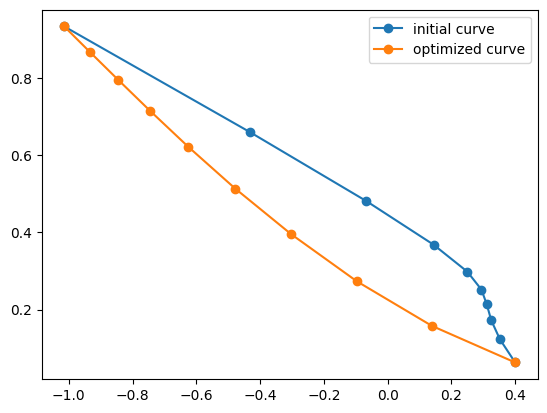

In [21]:
# plots initial curve
initial_curve = get_curve(initial_weights, point_0, point_1, n).detach().numpy()
plt.plot(initial_curve[:, 0], initial_curve[:, 1], '-o', label='initial curve')

# plots optimized curve
optimized_curve = get_curve(weights, point_0, point_1, n).detach().numpy()
plt.plot(optimized_curve[:, 0], optimized_curve[:, 1], '-o', label='optimized curve')

plt.legend()
plt.show()